# Model and Training

## Load the model

In [4]:
ON_COLAB = False  # Set to True if running on Google Colab

In [5]:
import os
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from diffusers import UNet2DModel, DDPMScheduler, DDIMScheduler
from utils import *

if ON_COLAB:
    !pip install dotenv

# Load environment variables from .env file
from dotenv import load_dotenv
load_dotenv()

# Configuration
data_root, model_save_dir, train_dir, test_dir = setup_environment(on_colab=ON_COLAB)

# Get device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Get the model
model, optimizer = get_unet_model(
    sample_size=IMAGE_SIZE,
    in_channels=1,
    out_channels=1,
    layers_per_block=2,
    block_out_channels=(64, 128, 256),
    down_block_types=("DownBlock2D", "DownBlock2D", "AttnDownBlock2D"),
    up_block_types=("AttnUpBlock2D", "UpBlock2D", "UpBlock2D"),
    dropout=0.1,
    device=DEVICE,
)

# Print model summary
print_model_summary(model)

# Load the model checkpoint
model_to_load_name = "ddim_unet_epoch227.pth"
isModelLoadedFromCheckpoint, model, optimizer, start_epoch = load_checkpoint(
    model_save_dir=model_save_dir,
    model_to_load_name=model_to_load_name,
    model=model,
    optimizer=optimizer,
    device=DEVICE
)

train_losses, val_losses = [], []

Data root: raw_data
Model save directory: checkpoints
Model moved to cuda
Model Summary:
Model Type: UNet2DModel
Number of Parameters: 15722625
Device: cuda:0
No checkpoint found at checkpoints/ddim_unet_epoch227.pth, starting fresh on cuda.


## Training and validation

In [5]:
import os
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.optim.lr_scheduler import CosineAnnealingLR
from torch.amp import autocast, GradScaler
from matplotlib import pyplot as plt
from utils import *

# Config
NUM_EPOCHS = 1
IMAGE_EXTENSIONS = (".png", ".jpg", ".jpeg")


# Dataset Preparation
def count_images(root_dir, extensions=IMAGE_EXTENSIONS):
    return sum(
        fname.lower().endswith(extensions)
        for _, _, filenames in os.walk(root_dir)
        for fname in filenames
    )


print(f"Training images before augmentation: {count_images(train_dir)}")
print(f"Validation images before augmentation: {count_images(test_dir)}")

train_loader = get_dataloader(
    root_dir=train_dir,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
)
test_loader = get_dataloader(
    root_dir=test_dir,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
)


print(f"Training samples: {len(train_loader.dataset)}")
print(f"Validation samples: {len(test_loader.dataset)}")

# DDIM schedulers setup
noise_scheduler, ddim_scheduler = get_schedulers()

model = torch.compile(model)
scaler = GradScaler(device=DEVICE)
scheduler = CosineAnnealingLR(optimizer, T_max=NUM_EPOCHS, eta_min=1e-6)

# Training Loop
train_losses, val_losses = [], []

print(
    f"Training on {DEVICE} | Batch Size: {BATCH_SIZE} | Epochs: {NUM_EPOCHS} | Starting at epoch {start_epoch}"
)

for epoch in range(1, NUM_EPOCHS + 1):
    model.train()
    total_train_loss = 0.0

    for step, (images, _) in enumerate(train_loader, 1):
        images = images.to(DEVICE)
        noise = torch.randn_like(images)
        timesteps = torch.randint(
            0, NUM_TRAIN_TIMESTEPS, (images.size(0),), device=DEVICE
        )

        optimizer.zero_grad()
        with autocast(device_type=DEVICE.type, enabled=True):
            noisy_images = noise_scheduler.add_noise(images, noise, timesteps)
            noise_pred = model(noisy_images, timesteps).sample
            loss = F.mse_loss(noise_pred, noise)

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        total_train_loss += loss.item()

        if step % 50 == 0 or step == len(train_loader):
            print(
                f"[Epoch {epoch}/{NUM_EPOCHS} | Step {step}/{len(train_loader)}] Train Loss: {loss.item():.6f}"
            )

    sample_images_from_validation(
        model=model,
        noise_scheduler=noise_scheduler,
        test_loader=test_loader,
        output_dir=model_save_dir,
        num_timesteps=NUM_TRAIN_TIMESTEPS,
        device=DEVICE,
        max_examples=1,
        epoch=epoch + start_epoch,
    )

    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Epoch {epoch} complete. Avg Train Loss: {avg_train_loss:.6f}")

    # Validation
    model.eval()
    total_val_loss = 0.0

    with torch.no_grad():
        for images, _ in test_loader:
            images = images.to(DEVICE)
            noise = torch.randn_like(images)
            timesteps = torch.randint(
                0, NUM_TRAIN_TIMESTEPS, (images.size(0),), device=DEVICE
            )

            with autocast(device_type=DEVICE.type, enabled=True):
                noisy_images = noise_scheduler.add_noise(images, noise, timesteps)
                noise_pred = model(noisy_images, timesteps).sample
                total_val_loss += F.mse_loss(noise_pred, noise).item()

    avg_val_loss = total_val_loss / len(test_loader)
    val_losses.append(avg_val_loss)
    print(f"Epoch {epoch} complete. Avg Validation Loss: {avg_val_loss:.6f}")

    ckpt_path = os.path.join(
        model_save_dir, f"ddim_unet_epoch{epoch + start_epoch}.pth"
    )
    save_checkpoint(
        model=model,
        optimizer=optimizer,
        epoch=epoch + start_epoch,
        path=ckpt_path,
    )

    # Save losses in history file
    # Path to the loss history file
    history_file = os.path.join(model_save_dir, "loss_history.txt")

    if isModelLoadedFromCheckpoint:
        with open(history_file, "a") as f:
            f.write(
                f"{epoch + start_epoch}\t{avg_train_loss:.6f}\t{avg_val_loss:.6f}\n"
            )
    else:
        with open(history_file, "w") as f:
            f.write("Epoch\tTrain Loss\tValidation Loss\n")
            f.write(
                f"{epoch + start_epoch}\t{avg_train_loss:.6f}\t{avg_val_loss:.6f}\n"
            )
    print(f"Losses saved to {history_file}")

Training images before augmentation: 3306
Validation images before augmentation: 327
Training samples: 26448
Validation samples: 2616
Training on cuda | Batch Size: 16 | Epochs: 1 | Starting at epoch 0


W0517 12:31:19.157000 30325 torch/_inductor/utils.py:1250] [0/0] Not enough SMs to use max_autotune_gemm mode


[Epoch 1/1 | Step 50/1653] Train Loss: 0.164627
[Epoch 1/1 | Step 100/1653] Train Loss: 0.135548
[Epoch 1/1 | Step 150/1653] Train Loss: 0.046433
[Epoch 1/1 | Step 200/1653] Train Loss: 0.030485
[Epoch 1/1 | Step 250/1653] Train Loss: 0.022205
[Epoch 1/1 | Step 300/1653] Train Loss: 0.029509
[Epoch 1/1 | Step 350/1653] Train Loss: 0.029612
[Epoch 1/1 | Step 400/1653] Train Loss: 0.026760
[Epoch 1/1 | Step 450/1653] Train Loss: 0.024615
[Epoch 1/1 | Step 500/1653] Train Loss: 0.034026
[Epoch 1/1 | Step 550/1653] Train Loss: 0.068296
[Epoch 1/1 | Step 600/1653] Train Loss: 0.053841
[Epoch 1/1 | Step 650/1653] Train Loss: 0.027844
[Epoch 1/1 | Step 700/1653] Train Loss: 0.023983
[Epoch 1/1 | Step 750/1653] Train Loss: 0.068536
[Epoch 1/1 | Step 800/1653] Train Loss: 0.015091
[Epoch 1/1 | Step 850/1653] Train Loss: 0.010542
[Epoch 1/1 | Step 900/1653] Train Loss: 0.081671
[Epoch 1/1 | Step 950/1653] Train Loss: 0.044287
[Epoch 1/1 | Step 1000/1653] Train Loss: 0.055220
[Epoch 1/1 | Step 10

Reconstructions:   0%|          | 0/164 [00:00<?, ?it/s]/home/enrico/Desktop/Project-Correction/.venv/lib/python3.12/site-packages/torch/_inductor/compile_fx.py:236: UserWarning: TensorFloat32 tensor cores for float32 matrix multiplication available but not enabled. Consider setting `torch.set_float32_matmul_precision('high')` for better performance.
  warnings.warn(
Reconstructions:   0%|          | 0/164 [00:22<?, ?it/s]

Epoch 1 complete. Avg Train Loss: 0.041796


Epoch 1 complete. Avg Validation Loss: 0.019517
Checkpoint salvato in: checkpoints/ddim_unet_epoch1.pth
Losses saved to checkpoints/loss_history.txt


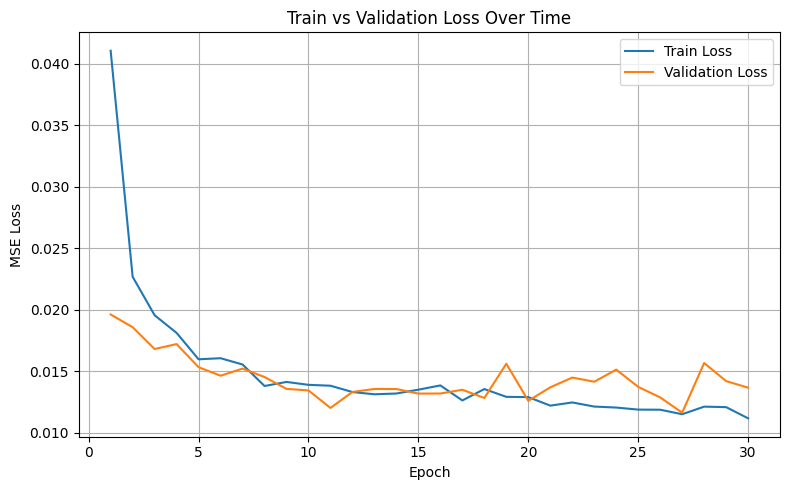

In [5]:
import os
import matplotlib.pyplot as plt

# Path to the loss history file
history_file = os.path.join(model_save_dir, "loss_history.txt")

# Check if file exists
if not os.path.exists(history_file):
    raise FileNotFoundError(f"Loss history file not found at: {history_file}")

# Read and parse loss history
epochs, train_losses, val_losses = [], [], []

with open(history_file, "r") as f:
    lines = f.readlines()[1:]  # Skip header
    for line in lines:
        epoch, train_loss, val_loss = line.strip().split("\t")
        epochs.append(int(epoch))
        train_losses.append(float(train_loss))
        val_losses.append(float(val_loss))

# Plot
plt.figure(figsize=(8, 5))
plt.plot(epochs, train_losses, label="Train Loss")
plt.plot(epochs, val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.title("Train vs Validation Loss Over Time")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [6]:
from utils import *

ON_COLAB = False  # Set to True if running on Google Colab

data_root, model_save_dir, train_dir, test_dir = setup_environment(on_colab=ON_COLAB)

RESULT_DIR = "result"
os.makedirs(RESULT_DIR, exist_ok=True)

# Get device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Setup model
model, optimizer = get_unet_model(device=DEVICE)


# Load the model checkpoint
model_to_load_name = "ddim_unet_epoch27.pth"
isModelLoadedFromCheckpoint, model, optimizer, start_epoch = load_checkpoint(
    model_save_dir=model_save_dir,
    model_to_load_name=model_to_load_name,
    model=model,
    optimizer=optimizer,
    device=DEVICE
)

# DDIM schedulers setup
noise_scheduler, ddim_scheduler = get_schedulers()

# Get the dataloader for test images
test_loader = get_dataloader(
    root_dir=test_dir,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
)

# Sample images
sample_images_from_validation(
    model=model,
    noise_scheduler=noise_scheduler,
    test_loader=test_loader,
    output_dir=RESULT_DIR,
    num_timesteps=NUM_TRAIN_TIMESTEPS,
    device=DEVICE,
    max_examples=10,
    epoch=start_epoch,
)

Data root: raw_data
Model save directory: checkpoints


/home/enrico/Desktop/Project-Correction/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/enrico/Desktop/Project-Correction/utils.py:255: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. W

Model moved to cuda
Loaded optimizer state from checkpoint 'checkpoints/ddim_unet_epoch27.pth'
Loaded checkpoint 'checkpoints/ddim_unet_epoch27.pth' (epoch 27)
Model ddim_unet_epoch27.pth loaded successfully to cuda, starting from epoch 27.


Reconstructions:   0%|          | 0/164 [00:00<?, ?it/s]


# Evaluation

Data root: raw_data
Model save directory: checkpoints
Model moved to cuda
Loaded optimizer state from checkpoint 'checkpoints/ddim_unet_epoch27.pth'
Loaded checkpoint 'checkpoints/ddim_unet_epoch27.pth' (epoch 27)
Model ddim_unet_epoch27.pth loaded successfully to cuda, starting from epoch 27.


Processing images: 100%|██████████| 5/5 [01:43<00:00, 20.65s/image]


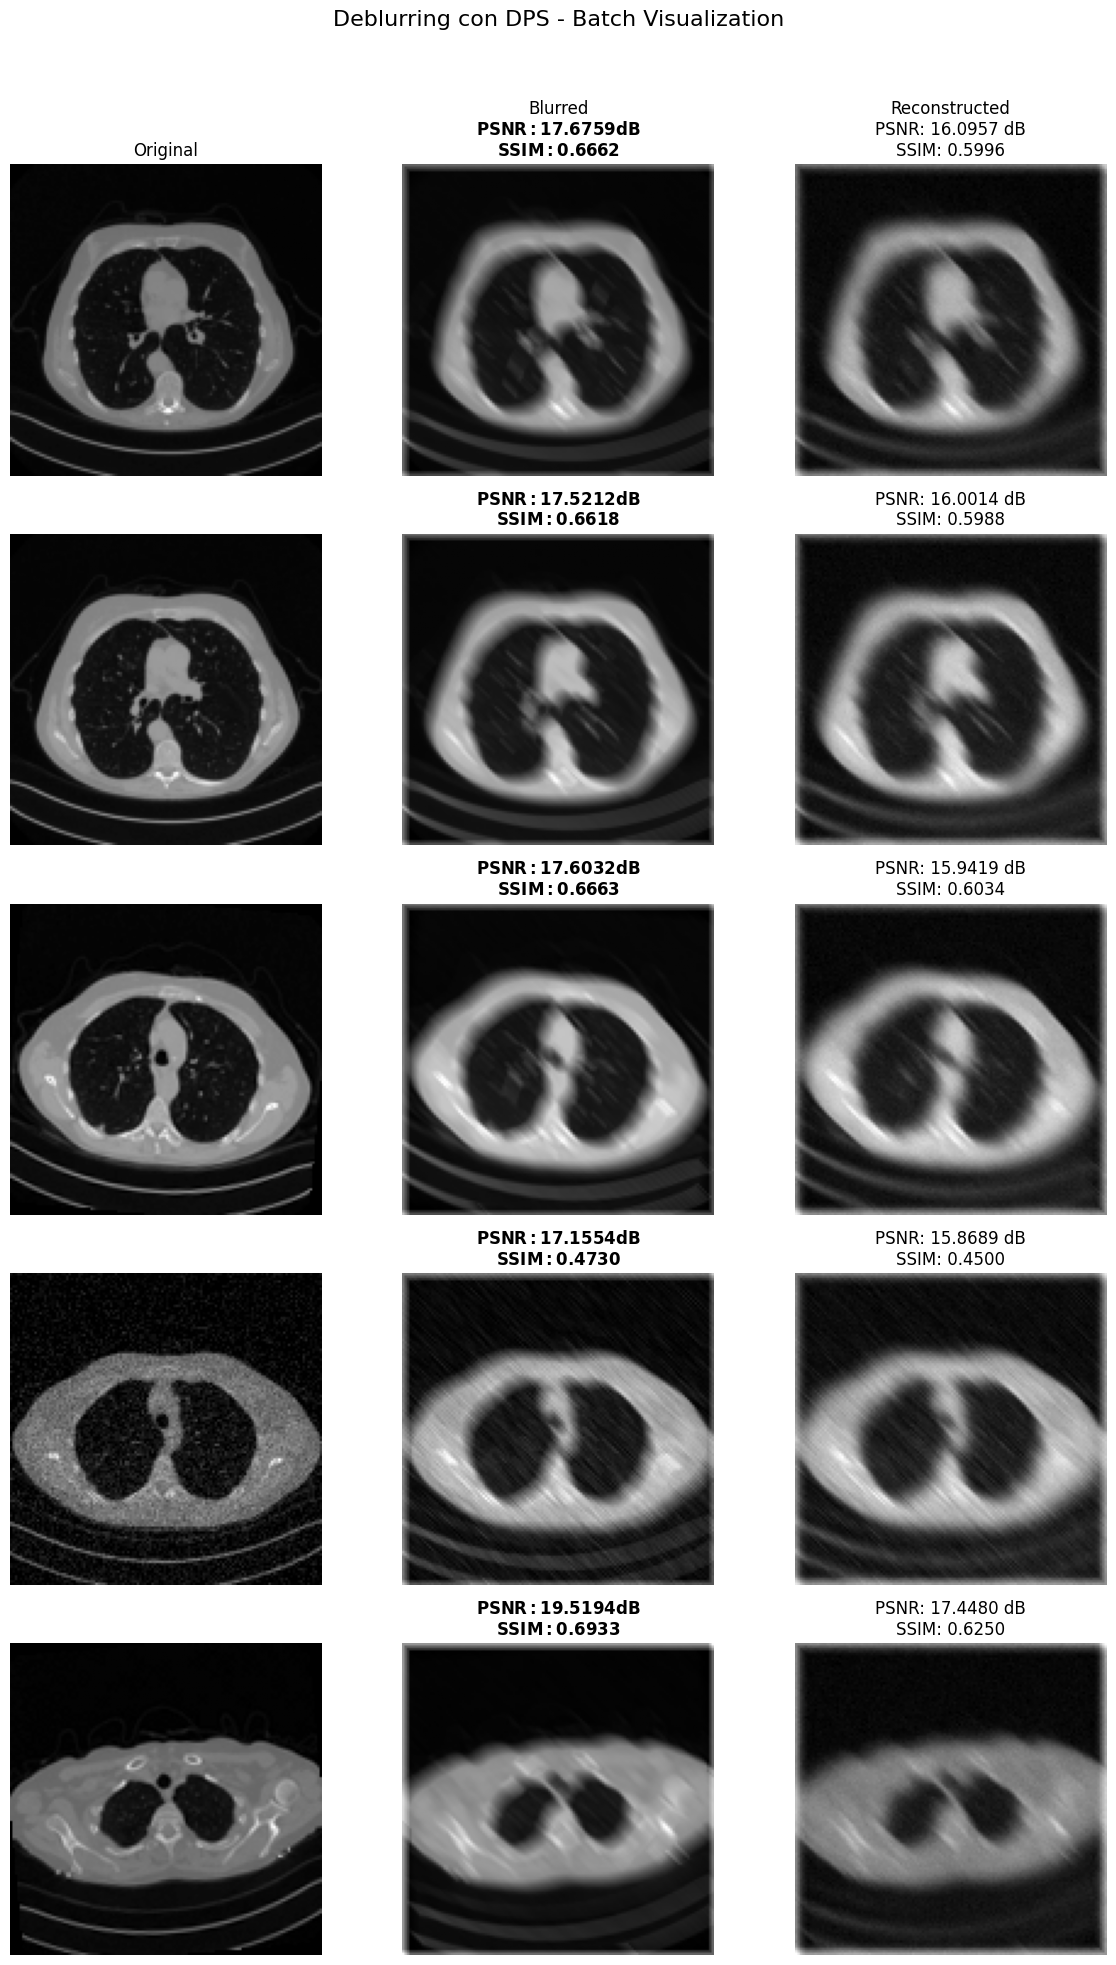

In [2]:
from IPPy import operators, metrics
from utils import *
from matplotlib import pyplot as plt
import random

ON_COLAB = False  # Set to True if running on Google Colab

# Set the seed for reproducibility
# random.seed(42)

data_root, model_save_dir, train_dir, test_dir = setup_environment(on_colab=ON_COLAB)

RESULT_DIR = "result"
os.makedirs(RESULT_DIR, exist_ok=True)

# Get device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Setup model
model, optimizer = get_unet_model(device=DEVICE)


# Load the model checkpoint
model_to_load_name = "ddim_unet_epoch27.pth"
isModelLoadedFromCheckpoint, model, optimizer, start_epoch = load_checkpoint(
    model_save_dir=model_save_dir,
    model_to_load_name=model_to_load_name,
    model=model,
    optimizer=optimizer,
    device=DEVICE,
)

# DDIM schedulers setup
noise_scheduler, ddim_scheduler = get_schedulers()

# Get the dataloader for test images
test_loader = get_dataloader(
    root_dir=test_dir,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
)

# crea un kernel di motion blur
kernel_size = 7  # ≥5 come consigliato
motion_angle = 45  # in gradi, a tua scelta
K = operators.Blurring(
    img_shape=(IMAGE_SIZE, IMAGE_SIZE),
    kernel_size=kernel_size,
    kernel_type="motion",
    motion_angle=motion_angle,
)


dps_deblur_and_plot(
    num_images=5,
    test_loader=test_loader,
    K=K,
    model=model,
    ddim_scheduler=ddim_scheduler,
    noise_scheduler=noise_scheduler,
    device=DEVICE,
)

/home/giova/Project-Correction/.venv/lib/python3.12/site-packages/IPPy/operators.py:16: UserWarning: CuPy not found. GPU acceleration for ASTRA via CuPy will be disabled.
  warnings.warn(


Data root: raw_data
Model save directory: checkpoints


/home/giova/Project-Correction/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Model moved to cuda


/home/giova/Project-Correction/utils.py:257: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(ckpt_path, map_location=device)


Loaded optimizer state from checkpoint 'checkpoints/ddim_unet_epoch27.pth'
Loaded checkpoint 'checkpoints/ddim_unet_epoch27.pth' (epoch 27)
Model ddim_unet_epoch27.pth loaded successfully to cuda, starting from epoch 27.


RED-Diff sampling: 100%|██████████| 1000/1000 [03:00<00:00,  5.53step/s]


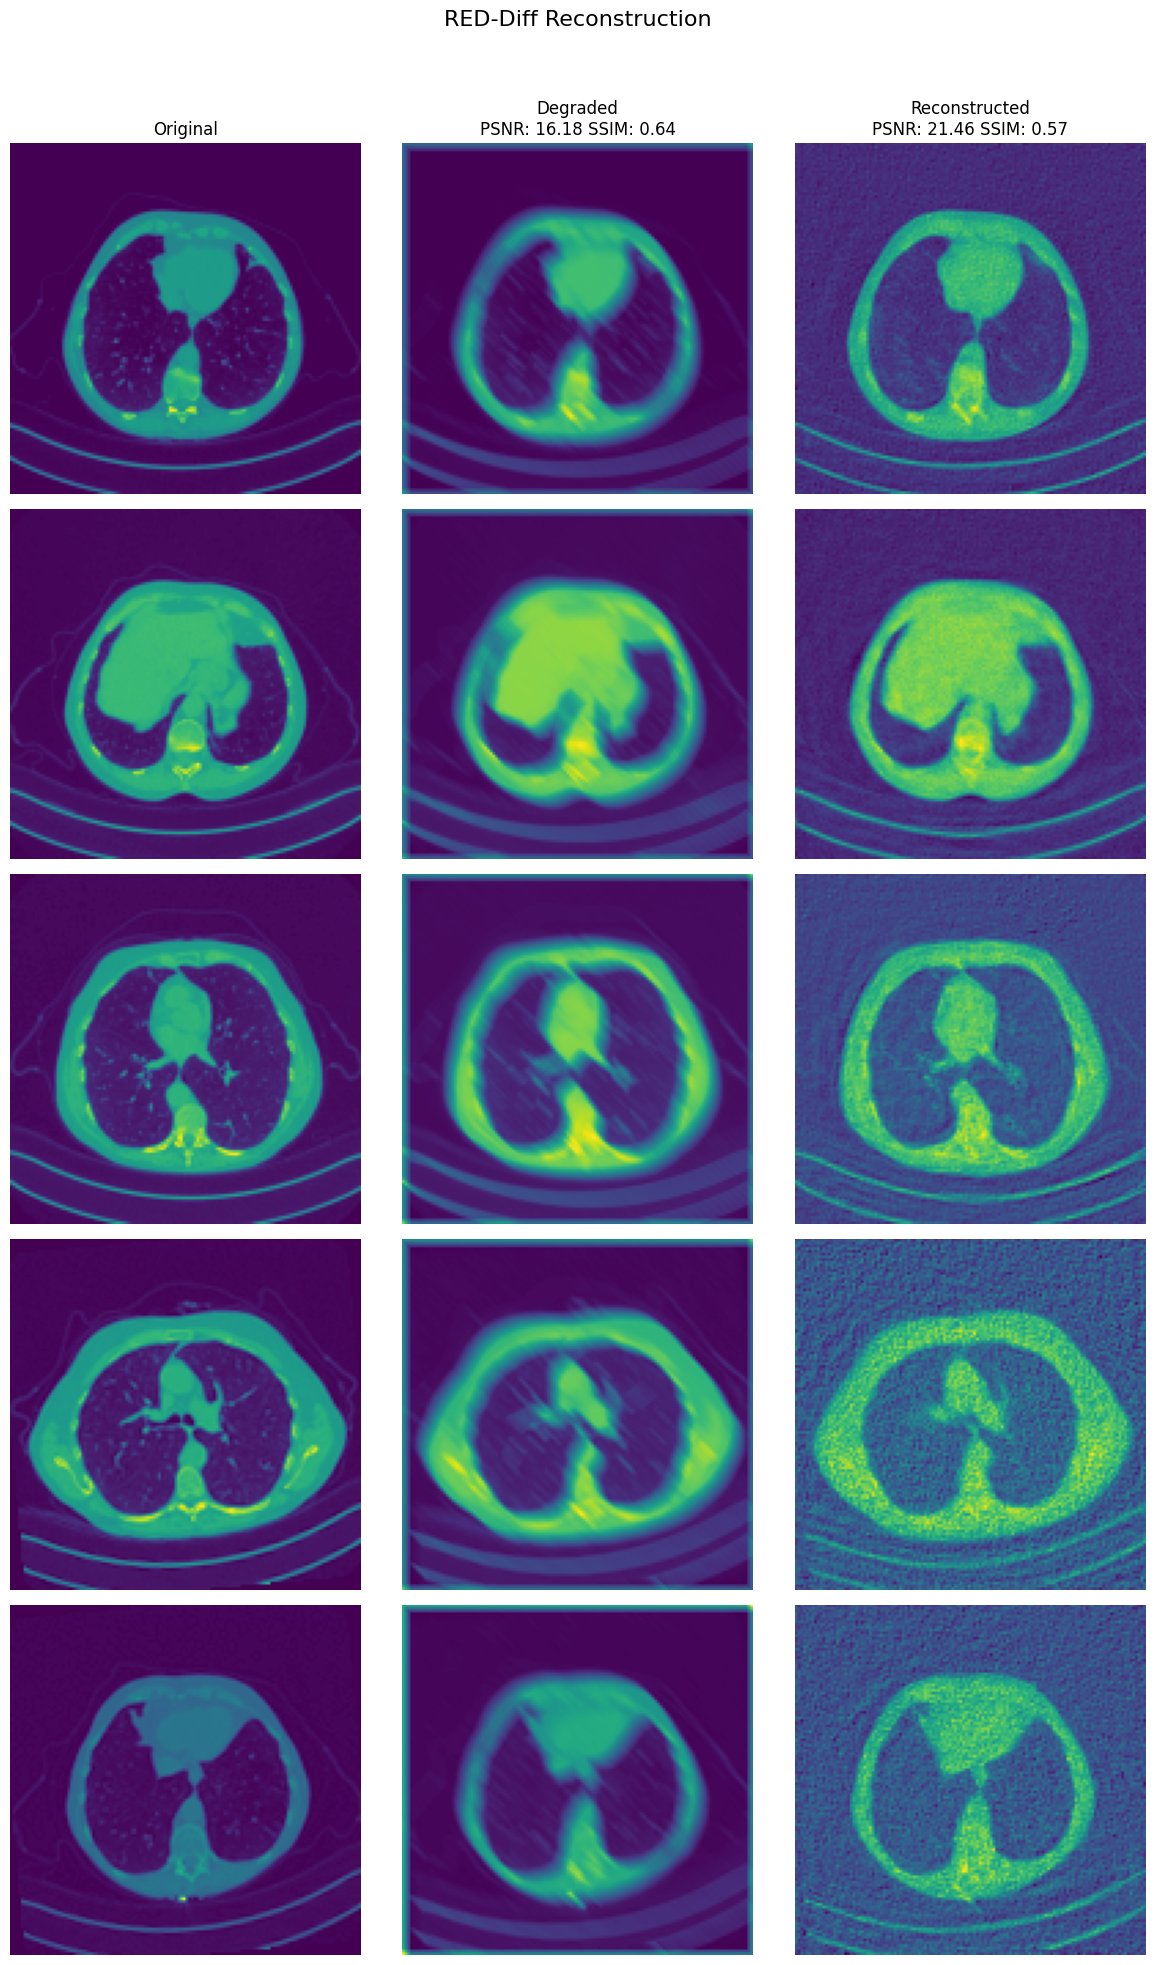

In [1]:
from IPPy import operators, metrics
from utils import *
from matplotlib import pyplot as plt
import random

ON_COLAB = False  # Set to True if running on Google Colab

# Set the seed for reproducibility
# random.seed(42)

data_root, model_save_dir, train_dir, test_dir = setup_environment(on_colab=ON_COLAB)

RESULT_DIR = "result"
os.makedirs(RESULT_DIR, exist_ok=True)

# Get device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Setup model
model, optimizer = get_unet_model(device=DEVICE)


# Load the model checkpoint
model_to_load_name = "ddim_unet_epoch27.pth"
isModelLoadedFromCheckpoint, model, optimizer, start_epoch = load_checkpoint(
    model_save_dir=model_save_dir,
    model_to_load_name=model_to_load_name,
    model=model,
    optimizer=optimizer,
    device=DEVICE,
)

# DDIM schedulers setup
noise_scheduler, ddim_scheduler = get_schedulers()

# Get the dataloader for test images
test_loader = get_dataloader(
    root_dir=test_dir,
    batch_size=BATCH_SIZE,
    image_size=IMAGE_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
)

# crea un kernel di motion blur
kernel_size = 7  # ≥5 come consigliato
motion_angle = 45  # in gradi, a tua scelta
K = operators.Blurring(
    img_shape=(IMAGE_SIZE, IMAGE_SIZE),
    kernel_size=kernel_size,
    kernel_type="motion",
    motion_angle=motion_angle,
)


red_diff_and_plot(
    num_images=5,
    test_loader=test_loader,
    K=K,
    model=model,
    noise_scheduler=noise_scheduler,
    device=DEVICE,
)